In [113]:
import scanpy as sc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import pertpy as pt
import seaborn as sns

In [93]:
sc.settings.figdir = "../results/similarity/"

In [8]:
adata = sc.read("../../data/limbAtlas/Metaphysis_Yang.h5Seura.h5ad")

In [9]:
adata

AnnData object with n_obs × n_vars = 11566 × 19776
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'coarse_label', 'sub.cluster', 'scDblFinder_class', 'Sample', 'Project', 'Core.Dataset', 'Limb.Atlas', 'Cranial.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Cre', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Cell.Count.After.QC', 'Origin'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

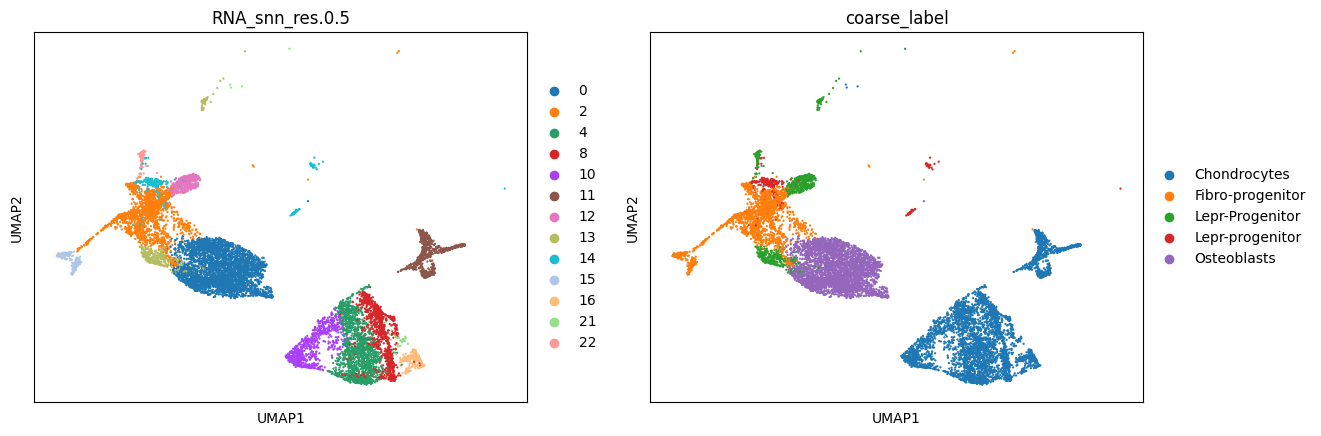

In [12]:
sc.pl.umap(adata,color=["RNA_snn_res.0.5",'coarse_label'])

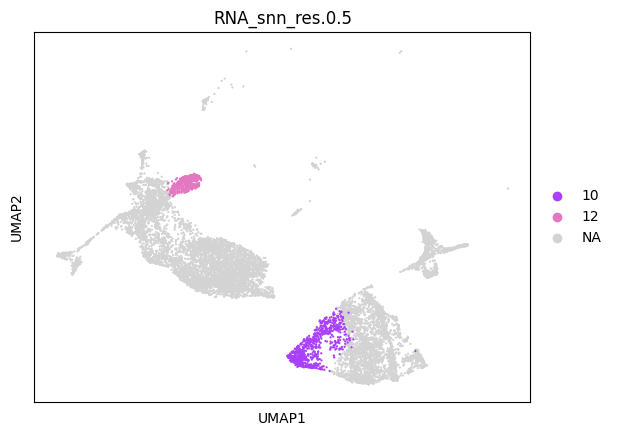

In [107]:
sc.pl.umap(adata,color=["RNA_snn_res.0.5"],groups=["10","12"],save="simulate.png")

In [95]:
adata.obs["shuffle_cluster_100"] = shuffle_percent(adata.obs["seurat_clusters"],100)

In [98]:
adata.obs["shuffle"] = adata.obs["seurat_clusters"].copy()

In [104]:
adata.obs["shuffle"][adata.obs["seurat_clusters"].isin(["12","10"])]  = np.array(adata_new.obs["shuffle_cluster_100"])

In [103]:
np.array(adata_new.obs["shuffle_cluster_100"])

array(['10', '10', '10', ..., '10', '10', '12'], dtype=object)

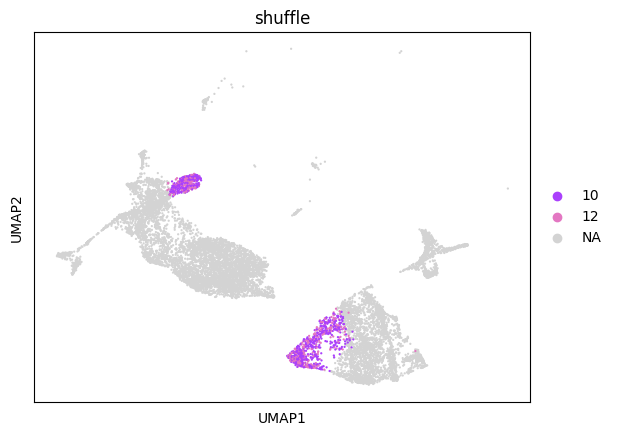

In [108]:
sc.pl.umap(adata,color=["shuffle"],groups=["10","12"],save="simulate_shuffle.png")

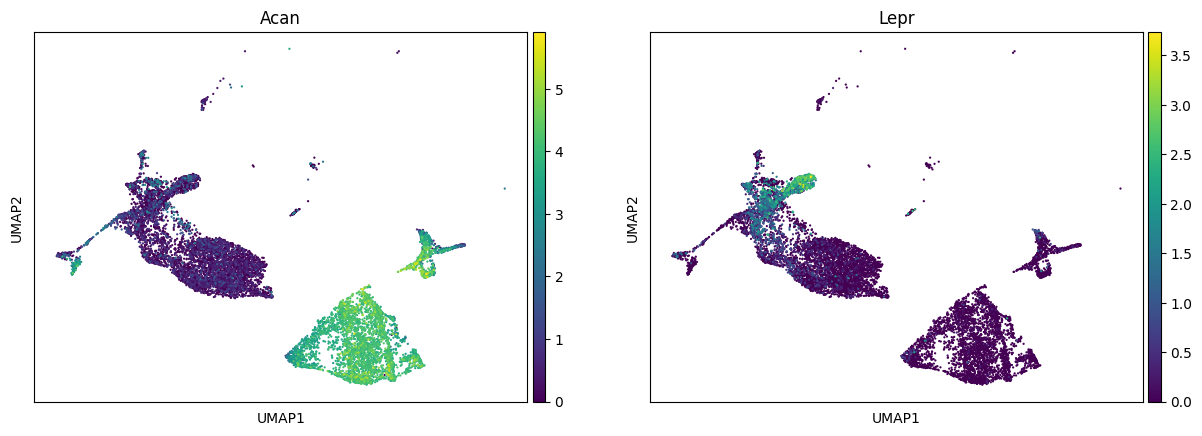

In [16]:
sc.pl.umap(adata,color=["Acan","Lepr"],use_raw=False)

In [21]:
adata.obs["seurat_clusters"].isin(["12","10"])

AAACGAATCGTAGTGT-1_1    False
AAACGCTAGACGCAGT-1_1    False
AAAGGATCATCTTCGC-1_1    False
AAAGGATTCAGTCCGG-1_1    False
AAAGGGCCAGGCAATG-1_1    False
                        ...  
TTTGACTGTATTTCCT-1_5    False
TTTGACTGTTGCATTG-1_5    False
TTTGACTTCTTGGGCG-1_5    False
TTTGGAGCAGCGACAA-1_5    False
TTTGGTTCACTACTTT-1_5    False
Name: seurat_clusters, Length: 11566, dtype: bool

In [22]:
adata_new = adata[adata.obs["seurat_clusters"].isin(["12","10"])]

In [28]:
def shuffle_percent(array,percent=0.2):
    # Convert to numpy array for easier manipulation
    array = np.array(array)
    
    # Calculate the number of elements to shuffle
    num_elements = len(array)
    num_to_shuffle = int(percent * num_elements)
    
    # Randomly select indices to shuffle
    indices = np.arange(num_elements)
    np.random.shuffle(indices)
    shuffle_indices = indices[:num_to_shuffle]
    
    # Extract and shuffle the selected elements
    elements_to_shuffle = array[shuffle_indices]
    np.random.shuffle(elements_to_shuffle)
    
    # Place shuffled elements back into the original array
    array[shuffle_indices] = elements_to_shuffle
    
    return array

In [58]:
orig_arr = adata_new.obs["seurat_clusters"]

In [62]:
shuffle_percent(orig_arr,percent=0)

array(['12', '10', '12', ..., '12', '12', '12'], dtype=object)

In [ ]:
shuf

In [46]:

def similarity(adata,label ,reduction, subsample_size):
    cell_ranks = set(adata.obs[label])
    downsampled_cells = []

    for cell_rank in cell_ranks:
        current_cells = np.where(adata.obs[label] == cell_rank)[0]
        if min(len(current_cells), subsample_size) < subsample_size:
            print(f"The current ident {cell_rank} is smaller than the sample size, adjust to the ident size")

        downsampled_cells.extend(np.random.choice(current_cells, size=min(len(current_cells), subsample_size), replace=False))

    downsample_seurat = adata[downsampled_cells,: ]

    # Prepare data for RandomForest
    X = downsample_seurat.obsm[reduction]
    y = LabelEncoder().fit_transform(downsample_seurat.obs[label])

    # Train a RandomForest classifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X, y)

    # Get the class probabilities
    class_probs = rf_model.predict_proba(X)
    class_labels = rf_model.classes_

    # Create a DataFrame from the class probabilities
    votes = pd.DataFrame(data=class_probs, columns=class_labels)
    votes['ident'] = downsample_seurat.obs[label].values

    # Calculate class probabilities per cluster
    summary = votes.groupby('ident').mean()

    # Normalize the summary matrix
    summary = summary.divide(summary.max(axis=1), axis=0).fillna(0)
    np.fill_diagonal(summary.values, 0)
    summary.columns=summary.index.values


    return summary


In [47]:
test= similarity(adata_new,"seurat_clusters","X_pca",1000)

The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


In [44]:
adata_new.obs["seurat_clusters"].cat.categories

Index(['10', '12'], dtype='object')

In [45]:
set(adata_new.obs["seurat_clusters"])

{'10', '12'}

In [39]:
test

,10,12
ident,,
10,0.000000,0.000891
12,0.001759,0.000000


In [29]:
shuffle_percent(adata_new.obs["seurat_clusters"])

array(['10', '12', '12', ..., '10', '10', '12'], dtype=object)

In [40]:
adata_new.obs["shuffle_cluster_100"] = shuffle_percent(adata_new.obs["seurat_clusters"],100)

/tmp/ipykernel_3051838/3059586929.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_new.obs["shuffle_cluster_100"] = shuffle_percent(adata_new.obs["seurat_clusters"],100)


In [48]:
test2= similarity(adata_new,"shuffle_cluster_100","X_pca",1000)

The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


In [49]:
test2

,10,12
ident,,
10,0.0000,0.178036
12,0.3169,0.000000


In [54]:
sequence = list(range(0,110, 10))

In [55]:
sequence

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [69]:
metricList = list()
for i in list(range(0,110, 10)):
    print(i)
    i = i/100
    adata_new.obs["shuffle"] = shuffle_percent(adata_new.obs["seurat_clusters"],i)
    metric = similarity(adata_new,"shuffle","X_pca",1000)
    metric = (metric.iloc[0,1] + metric.iloc[1,0])/2
    metricList.append(metric)



0
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size
10
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size
20
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size
30
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size
40
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size
50
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size
60
The current ident 10 is smaller 

In [68]:
(metricList[1].iloc[0,1] + metricList[1].iloc[1,0])/2

0.0476896930101134

In [72]:
metricDf = pd.DataFrame(metricList)
metricDf.columns = ["Similarity"]
metricDf.index = sequence

In [90]:
!mkdir ../results/similarity

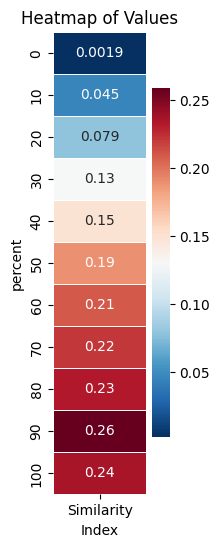

In [91]:
# Plotting the heatmap
plt.figure(figsize=(1.5, 6))  # Adjust size as needed
sns.heatmap(metricDf, cmap='RdBu_r', annot=True, cbar=True, linewidths=0.5)
plt.title('Heatmap of Values')
plt.xlabel('Index')
plt.ylabel('percent')
plt.savefig("../results/similarity/simulate_hm.pdf")
plt.show()

In [115]:
adata_new

AnnData object with n_obs × n_vars = 1282 × 19776
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'coarse_label', 'sub.cluster', 'scDblFinder_class', 'Sample', 'Project', 'Core.Dataset', 'Limb.Atlas', 'Cranial.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Cre', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Cell.Count.After.QC', 'Origin', 'shuffle_cluster_100', 'shuffle'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'coarse_label_colors', 'RNA_snn_res.0.5_colors', 'shuffle_cluster_100_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [118]:
distance = pt.tl.Distance("edistance", obsm_key="X_pca")
df = distance.pairwise(adata_new, groupby="seurat_clusters")

Output()

In [135]:
metricList = list()
metricList2 = list()
metricList3 = list()
metricList4 = list()
metricList5 = list()
metricList6 = list()
for i in list(range(0,101, 1)):
    print(i)
    i = i/100
    adata_new.obs["shuffle"] = shuffle_percent(adata_new.obs["seurat_clusters"],i)
    metric1 = similarity(adata_new,"shuffle","X_pca",1000)
    metric1 = (metric1.iloc[0,1] + metric1.iloc[1,0])/2
    df = distance.pairwise(adata_new, groupby="shuffle")
    metric = (df.iloc[0,1] + df.iloc[1,0])/2
    metricList.append(metric1)
    metricList2.append(metric)

    ## distance 2 ------
    distance_pairwise = pt.tl.Distance("mean_pairwise", obsm_key="X_pca")
    df = distance_pairwise.pairwise(adata_new, groupby="shuffle")
    metric = (df.iloc[0,1] + df.iloc[1,0])/2
    metricList3.append(metric)
    # distance 4--------------
    distance_euclidean = pt.tl.Distance(metric="euclidean", obsm_key="X_pca")
    df = distance_euclidean.pairwise(adata_new, groupby="shuffle")
    metric = (df.iloc[0,1] + df.iloc[1,0])/2
    metricList4.append(metric)
    # distance 5----------------------
    distance_wasserstein = pt.tl.Distance(metric="wasserstein", obsm_key="X_pca")
    df = distance_wasserstein.pairwise(adata_new, groupby="shuffle")
    metric = (df.iloc[0,1] + df.iloc[1,0])/2
    metricList5.append(metric)
    #== distance 6----------------------------
    distance_mmd = pt.tl.Distance("mmd", obsm_key="X_pca")
    df = distance_mmd.pairwise(adata_new, groupby="shuffle")
    metric = (df.iloc[0,1] + df.iloc[1,0])/2
    metricList6.append(metric)

0
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

1
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

2
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

3
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

4
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

5
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

6
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

7
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

8
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

9
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

10
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

11
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

12
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

13
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

14
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

15
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

16
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

17
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

18
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

19
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

20
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

21
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

22
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

23
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

24
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

25
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

26
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

27
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

28
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

29
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

30
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

31
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

32
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

33
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

34
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

35
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

36
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

37
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

38
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

39
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

40
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

41
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

42
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

43
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

44
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

45
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

46
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

47
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

48
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

49
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

50
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

51
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

52
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

53
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

54
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

55
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

56
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

57
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

58
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

59
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

60
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

61
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

62
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

63
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

64
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

65
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

66
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

67
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

68
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

69
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

70
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

71
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

72
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

73
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

74
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

75
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

76
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

77
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

78
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

79
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

80
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

81
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

82
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

83
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

84
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

85
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

86
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

87
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

88
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

89
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

90
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

91
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

92
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

93
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

94
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

95
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

96
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

97
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

98
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

99
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

100
The current ident 10 is smaller than the sample size, adjust to the ident size
The current ident 12 is smaller than the sample size, adjust to the ident size


Output()

Output()

Output()

Output()

Output()

In [137]:
metricList

[0.0016219700456468317,
 0.004711264521558132,
 0.010810775526438676,
 0.009919803781696554,
 0.021196413635472557,
 0.025976238542803634,
 0.03505313124890129,
 0.024342930133751405,
 0.037689944867788004,
 0.0361340946144481,
 0.043948613407335316,
 0.042171429387124586,
 0.06620819277545428,
 0.05581572781387814,
 0.05793232781481274,
 0.06609664404429513,
 0.06621169492793637,
 0.07572895818008842,
 0.0679774381756431,
 0.07369984915626883,
 0.08127501894934389,
 0.09248692033765665,
 0.09348760440056475,
 0.09779228739599927,
 0.10033591770192286,
 0.10674727005407113,
 0.10642490816213135,
 0.10903290787747011,
 0.12281909409659758,
 0.13318779070775777,
 0.12374363313406153,
 0.12653097242582262,
 0.13592834882115065,
 0.12432511326414386,
 0.13577036093436878,
 0.14671404646461061,
 0.13029959523364693,
 0.14704906866152298,
 0.14718682115266554,
 0.14949174957925446,
 0.1502900443052182,
 0.16080817509840648,
 0.16610492610637653,
 0.16148471024292377,
 0.17158181114251309,
 0

In [141]:
ideal_array = list(range(0, 101))

In [142]:
from scipy.stats import spearmanr, kendalltau
spearman_corr, _ = spearmanr(metricList, ideal_array)

In [143]:
spearman_corr

0.9925451368666277

In [149]:
spearman_corr2, _ = spearmanr(metricList2, ideal_array)
spearman_corr3, _ = spearmanr(metricList3, ideal_array)
spearman_corr4, _ = spearmanr(metricList4, ideal_array)
spearman_corr5, _ = spearmanr(metricList5, ideal_array)
spearman_corr6, _ = spearmanr(metricList6, ideal_array)

In [147]:
spearman_corr2
spearman_corr3

-0.9978567268491554

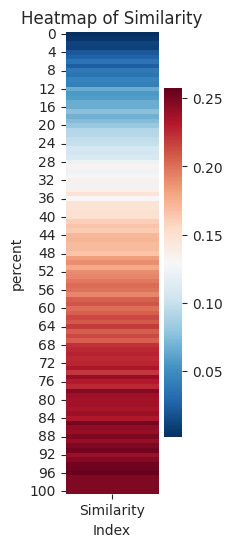

In [159]:
metricDf = pd.DataFrame(metricList)
metricDf.columns = ["Similarity"]
metricDf.index = ideal_array
plt.figure(figsize=(1.5, 6))  # Adjust size as needed
sns.heatmap(metricDf, cmap='RdBu_r', annot=False, cbar=True, linewidths=0)
plt.title('Heatmap of Similarity')
plt.xlabel('Index')
plt.ylabel('percent')
plt.savefig("../results/similarity/hetmap_100.pdf")
plt.show()